In [1]:
# | export
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
import pandas as pd

# Utils Functions

In [2]:
# | export
def plot_fitted_odes(data_fitted, t_fit, measured, model_result, xlim=None, ylim=None, t_name='time'):
    import seaborn as sns
    import pandas as pd
    time = measured[:,0]
    x = measured[:,1:]
    df_x = pd.DataFrame(x, columns=[f'x{i}' for i in range(x.shape[1])], index=pd.Series(time,  name=t_name)).reset_index().melt(id_vars=t_name, value_name='count', var_name='species')
    
    df_fit = pd.DataFrame(data=data_fitted, index=pd.Series(t_fit, name=t_name), columns=[f'fit_x{i}' for i in range(data_fitted.shape[1])]).reset_index()
    df_fit_long = df_fit.melt(id_vars=t_name, var_name='fit_curve_name', value_name='count')
    
    ax = sns.lineplot(data = df_fit_long, x=t_name, y='count', hue='fit_curve_name')
    ax = sns.scatterplot(data=df_x, x=t_name, y='count', hue='species')
    if xlim != None:
        ax.set_xlim(xlim)
    if ylim != None:
        ax.set_ylim(ylim)
        
        
    report_fit(model_result)
    plt.show()
    return ax

# ODE model n1

models and fit functions for ODEs coming from a master equation. 
linear reaction where you just have forward rates. You can set creation rates (`kinp`) and distruction rates (`kout`) by initialize_params 


example:
$$ \xrightarrow{k_{inp}} \text{AA..AA} \xrightarrow{k_0} \text{AA..A} \xrightarrow{k_1} ... \xrightarrow{k_{n-1}} \text{AA} \xrightarrow{k_{out}}$$

In [3]:
#| default_exp ode

In [4]:
# | export
def initialize_params(data, initial_guess='random', kin_guess=None, kout_guess=None, initial_guess_bounds=[0.0001, 1], vary_initial_conditions=False):
    """ Inizialize parameters for ODEs. 
    If initial_guess is 'random' then a vector of random variables [0,1) is created
    If kin_guess and kout_guess are None then the model doesn't include creation and distruction rate, provide a value otherwise"""
    
    initial_conditions = list(data[0,:])  
    if initial_guess == 'random':
        initial_guess = np.random.rand(len(initial_conditions) -1)
    params = Parameters()

    for nm,i in enumerate(initial_conditions):
        params.add('x'+str(nm + 1)+'0', value=i, vary=vary_initial_conditions)

    # creation rate   
    if kin_guess == None:
        params.add('k_inp', value=0, vary=False)
    else:
        params.add('k_inp', value=kin_guess)

    # reaction rates 
    for nm, k in enumerate(initial_guess):
        params.add('k'+str(nm), value=k, min=initial_guess_bounds[0], max=initial_guess_bounds[1])

    # distruction rate   
    if kout_guess == None:
        params.add('k_out', value=0, vary=False)
    else:
        params.add('k_out', value=kout_guess)
    return params

In [5]:
x = np.array([[1,1,2,3], [1, 4,5,6]])
initial_guess= [0.1, 0.2, 0.3]
test_init_params = initialize_params(x, 'random', kin_guess=0.3, kout_guess=0.2)

test_init_params

name,value,initial value,min,max,vary
x10,1.00000000,1,-inf,inf,False
x20,1.00000000,1,-inf,inf,False
x30,2.00000000,2,-inf,inf,False
x40,3.00000000,3,-inf,inf,False
k_inp,0.30000000,0.3,-inf,inf,True
k0,0.77014600,0.7701459951068893,1.0000e-04,1.00000000,True
k1,0.57643164,0.576431636868473,1.0000e-04,1.00000000,True
k2,0.88912226,0.8891222578036087,1.0000e-04,1.00000000,True
k_out,0.20000000,0.2,-inf,inf,True


In [6]:
x = np.array([[1,2,3], [4,5,6]])
initial_guess= [0.1, 0.2, 0.3]
test_init_params = initialize_params(x, initial_guess)
assert test_init_params['k1'] == 0.2
assert list(test_init_params.keys()) == ['x10', 'x20', 'x30', 'k_inp', 'k0', 'k1', 'k2', 'k_out' ]

In [7]:
test_init_params

name,value,initial value,min,max,vary
x10,1.00000000,1,-inf,inf,False
x20,2.00000000,2,-inf,inf,False
x30,3.00000000,3,-inf,inf,False
k_inp,0.00000000,0,-inf,inf,False
k0,0.10000000,0.1,1.0000e-04,1.00000000,True
k1,0.20000000,0.2,1.0000e-04,1.00000000,True
k2,0.30000000,0.3,1.0000e-04,1.00000000,True
k_out,0.00000000,0,-inf,inf,False


In [8]:
# | export 
def k_matrix(params):
    params_k_list = [k for k in params.keys() if 'k' in k]
    m = len(params_k_list)
    n = m - 1

    k = np.eye(n,m) - np.eye(n,m, k=1)
    k_values = [params[k] for k in params_k_list]
    return k_values * k

In [9]:
test_params = {'a':1/3,'kin':0,'k1':1,'k2':20, 'k3':300, 'kout':1}
out = np.array([[0,-1, 0, 0, 0], 
                [0,1,-20, 0, 0], 
                [0,0, 20, -300, 0], 
                [0, 0, 0, 300, -1]])
assert (k_matrix(test_params) == out).all()

In [10]:
k_matrix(test_params)

array([[   0.,   -1.,    0.,    0.,    0.],
       [   0.,    1.,  -20.,    0.,    0.],
       [   0.,    0.,   20., -300.,    0.],
       [   0.,    0.,    0.,  300.,   -1.]])

In [11]:
# | export 
def _master_equations(y, t, paras):
    """
    Your system of differential equations
    # f0 = -k0 * x1
    # f1 = k0 * x1 - k1 * x2
    # ...
    # fn-1 = kn-2 * x2 - kn-1 * x3
    # fn = kn-1 * xn-1
    fn need to be solve using odeint
    """
    y = np.insert(y, 0, 1)

    rates = k_matrix(paras)
    # print('rates shape', rates.shape)
    # print('y shape', y)
    dydt = rates.dot(y)
    # print('out shape', dydt.shape)
    return dydt

In [12]:
test_params = {'a':1/3, 'k_in':1, 'k1':4,'k2':6, 'k3':9, 'k_out':9}
M = np.array([[1, -4, 0, 0, 0], 
              [0, 4, -6, 0, 0], 
              [0, 0, 6, -9, 0], 
              [0, 0, 0, 9, -9]])
xs = np.array([ 1/4, 1/6, 1/9, 1/3])
out = np.array([0, 0, 0, -2])
_master_equations(xs, 0, test_params)
# 

assert (_master_equations(xs, 0, test_params) == out.T).all()

In [13]:
# | export 
def ode_solver(t, x0, paras):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(_master_equations, x0, t, args=(paras,))
    return x

In [14]:
# | export 
def plot_fitted(t_fit, data_fitted, measured, model_result):
    t_measured = measured[:,0]
    x_measured =  measured[:,1:]
    # plot fitted data
    plt.plot(t_fit, data_fitted, '-', linewidth=2, color='red', label='fitted data')
    for i, xi_measured in enumerate(x_measured.T):
        plt.scatter( t_measured, xi_measured, marker='o', color='b', label= 'X' + str(i))
    plt.legend()
    plt.xlim([0, np.max(t_measured)])
    plt.ylim([0, 1.1 * np.max(data_fitted)])
    # display fitted statistics
    report_fit(model_result)

    plt.show()

In [15]:
# | export 
def residual(paras, t, data, eps=None):

    """
    compute the residual between actual data and fitted data
    """
    x0 = [paras[x].value for x in paras.keys() if 'x' in x]
    model = ode_solver(t, x0, paras)
    if eps is None:
        return ((model - data)).ravel()
    return ((model-data) / eps).ravel()

In [16]:
# | export 
def fit_ode(residual_fn, params, time, x, method='leastsq', eps=None):
    kws = {'eps':eps}
    return minimize(residual_fn, params, args=(time, x), kws=kws, method=method)

## Simulate Process no k_in k_out

$$\text{AA..AA} \xrightarrow{k_0} \text{AA..A} \xrightarrow{k_1} ... \xrightarrow{k_{n-1}} \text{AA}$$

In [17]:
# Simulation using kinp and kout parameters fixed to zero
# fixed error
time_limit = 10
num_chain_reaction = 4

k0 = 0.3
k1 = 0.8
k2 = 0.8

x = np.zeros((time_limit, num_chain_reaction))
x[0,:] = np.array([1000, 0, 0 , 0])

noise_dev = np.random.gamma(3, 0.8, (time_limit, 4))
scale = 0.1


for t in range(1, time_limit):
    proc1, proc2, proc3 = np.random.normal(scale= scale), np.random.normal(scale= scale), np.random.normal(scale= scale)
    x[t, 0] = x[t-1, 0] - (x[t-1, 0] * (k0 + proc1))
    x[t, 1] = x[t-1, 1] + ((x[t-1, 0] * (k0 + proc1)) - (x[t-1, 1] * (k1 + proc2)))
    x[t, 2] = x[t-1, 2] + ((x[t-1, 1] * (k1 + proc2)) - (x[t-1, 2] * (k2 + proc3)))
    x[t, 3] = x[t-1, 3] + (x[t-1, 2] * (k2 + proc3))
x = np.abs(x)

In [18]:
# Fit

# set parameters including bounds; you can also fix parameters (use vary=False)
params = initialize_params(x)
eps= None
time = np.arange(time_limit)

# fit model
result = minimize(residual, params, args=(time, x),kws=eps, method='leastsq')  # leastsq nelder
# check results of the fit
t_fit = np.linspace(0., 10., 100)
data_fitted = ode_solver(t_fit, x[0,:], result.params)




In [19]:
params

name,value,initial value,min,max,vary
x10,1000.00000,1000.0,-inf,inf,False
x20,0.00000000,0.0,-inf,inf,False
x30,0.00000000,0.0,-inf,inf,False
x40,0.00000000,0.0,-inf,inf,False
k_inp,0.00000000,0,-inf,inf,False
k0,0.45159166,0.45159165568096127,1.0000e-04,1.00000000,True
k1,0.19124773,0.19124772690655567,1.0000e-04,1.00000000,True
k2,0.93037351,0.9303735092657754,1.0000e-04,1.00000000,True
k_out,0.00000000,0,-inf,inf,False


In [20]:
x


array([[1000.        ,    0.        ,    0.        ,    0.        ],
       [ 731.2951243 ,  268.7048757 ,    0.        ,    0.        ],
       [ 476.64694941,  286.0307744 ,  237.32227619,    0.        ],
       [ 329.12342657,  199.02425747,  259.89757651,  211.95473945],
       [ 234.41068836,  134.42296867,  195.58437764,  435.58196533],
       [ 159.04532461,  128.90248449,   91.03515723,  621.01703366],
       [ 114.90137227,   68.62683677,  111.53634556,  704.9354454 ],
       [  62.73139215,   55.50155817,   99.7876936 ,  781.97935608],
       [  42.63228439,   38.79144049,   65.25864931,  853.3176258 ],
       [  26.66791785,   24.54303027,   50.05754159,  898.73151029]])

/home/e.marinelli_cbs-niob.local/.conda/envs/diffdig/lib/python3.7/site-packages/lmfit/printfuncs.py:177: RuntimeWarning: invalid value encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 40
    # variables        = 3
    chi-square         = 53301.2433
    reduced chi-square = 1440.57414
    Akaike info crit   = 293.793419
    Bayesian info crit = 298.860058
[[Variables]]
    x10:    1000 (fixed)
    x20:    0 (fixed)
    x30:    0 (fixed)
    x40:    0 (fixed)
    k_inp:  0 (fixed)
    k0:     0.38183811 +/- 0.01486957 (3.89%) (init = 0.4515917)
    k1:     0.79796273 +/- 0.06163706 (7.72%) (init = 0.1912477)
    k2:     0.78641225 +/- 0.06399689 (8.14%) (init = 0.9303735)
    k_out:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k1, k2) = -0.358
    C(k0, k1) = -0.270
    C(k0, k2) = -0.253


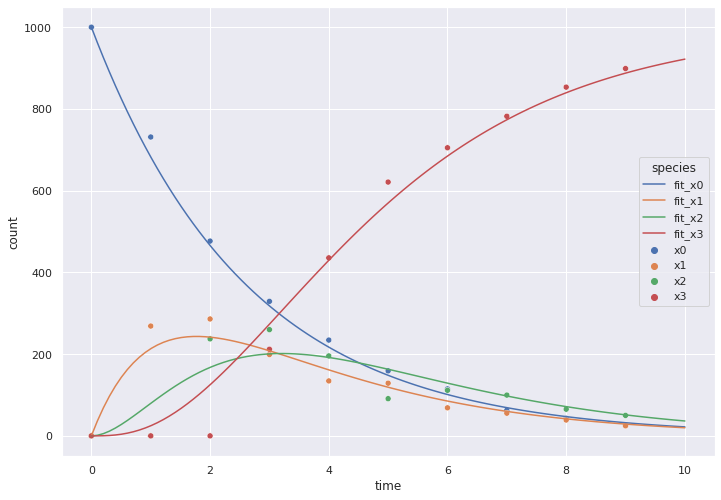

<AxesSubplot:xlabel='time', ylabel='count'>

In [21]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
measured = np.concatenate((time.reshape(-1,1), x), axis=1)
plot_fitted_odes(data_fitted, t_fit, measured, result)

## Simulate Process with k_in k_out

In [22]:
# Simulation using kinp and kout parameters fixed to zero
# fixed error
time_limit = 40
num_chain_reaction = 4

k_inp = 0.5
k0 = 0.3
k1 = 0.1
k2 = 0.6
k_out = 0.8

x = np.zeros((time_limit, num_chain_reaction))
x[0,:] = np.array([0, 0, 0 , 0])

noise_dev = np.random.gamma(3, 0.8, (time_limit, 4))
scale = 0.1


for t in range(1, time_limit):
    proc0, proc1, proc2, proc3, procout = np.random.randn(5) * scale
    x[t, 0] = np.max(x[t-1, 0] - (x[t-1, 0] * (k0 + proc1)) + (k_inp + proc0), 0)
    x[t, 1] = x[t-1, 1] + ((x[t-1, 0] * (k0 + proc1)) - (x[t-1, 1] * (k1 + proc2)))
    x[t, 2] = x[t-1, 2] + ((x[t-1, 1] * (k1 + proc2)) - (x[t-1, 2] * (k2 + proc3)))
    x[t, 3] = x[t-1, 3] + (x[t-1, 2] * (k2 + proc3)) - (x[t-1, 3] * (k_out + procout))
x = np.abs(x)

In [23]:
df = pd.DataFrame(np.c_[np.arange(time_limit),x], columns=['t', 'x0', 'x1', 'x2', 'x3'])
df



,t,x0,x1,x2,x3
0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,0.361933,0.000000,0.000000,0.000000
2,2.0,0.900933,0.052942,0.000000,0.000000
3,3.0,1.150503,0.258562,0.005880,0.000000
4,4.0,1.450129,0.452096,0.007369,0.004150
5,5.0,1.579261,0.818011,0.009886,0.003062
6,6.0,1.639351,1.101086,0.191035,0.006887
7,7.0,1.398290,1.498996,0.404420,0.110469
8,8.0,1.541398,1.517028,0.441546,0.284943
9,9.0,1.351384,2.150460,0.119531,0.366578


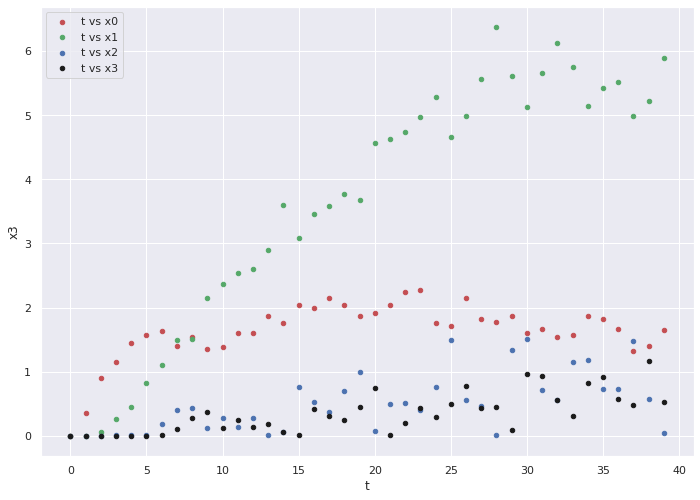

In [24]:
import pandas as pd


f,ax = plt.subplots(1)
for x_ax,y_ax,c in zip(['t'] * (len(df.columns)-1),df.columns[1:],['r','g','b', 'k']):
    df.plot(kind='scatter', 
            x=x_ax, 
            y=y_ax, 
            color=c, 
            ax=ax, 
            label='{} vs {}'.format(x_ax,y_ax)
            )

In [25]:
params

name,value,initial value,min,max,vary
x10,1000.00000,1000.0,-inf,inf,False
x20,0.00000000,0.0,-inf,inf,False
x30,0.00000000,0.0,-inf,inf,False
x40,0.00000000,0.0,-inf,inf,False
k_inp,0.00000000,0,-inf,inf,False
k0,0.45159166,0.45159165568096127,1.0000e-04,1.00000000,True
k1,0.19124773,0.19124772690655567,1.0000e-04,1.00000000,True
k2,0.93037351,0.9303735092657754,1.0000e-04,1.00000000,True
k_out,0.00000000,0,-inf,inf,False


In [26]:
# Fit

# set parameters including bounds; you can also fix parameters (use vary=False)
params = initialize_params(x, kin_guess=0.5, kout_guess=0.5)
eps= None
time = np.arange(time_limit)

# fit model
result = minimize(residual, params, args=(time, x),kws=eps, method='leastsq')  # leastsq nelder
# check results of the fit
t_fit = np.linspace(0., 40., 1000)
data_fitted = ode_solver(t_fit, x[0,:], result.params)




/home/e.marinelli_cbs-niob.local/.conda/envs/diffdig/lib/python3.7/site-packages/lmfit/printfuncs.py:177: RuntimeWarning: invalid value encountered in double_scalars
  spercent = f'({abs(par.stderr/par.value):.2%})'


[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 160
    # variables        = 5
    chi-square         = 13.3254595
    reduced chi-square = 0.08597071
    Akaike info crit   = -387.679578
    Bayesian info crit = -372.303709
[[Variables]]
    x10:    0 (fixed)
    x20:    0 (fixed)
    x30:    0 (fixed)
    x40:    0 (fixed)
    k_inp:  0.47007056 +/- 0.01500855 (3.19%) (init = 0.5)
    k0:     0.25709588 +/- 0.00976043 (3.80%) (init = 0.2084555)
    k1:     0.07440385 +/- 0.00412389 (5.54%) (init = 0.6495825)
    k2:     0.49693199 +/- 0.05111573 (10.29%) (init = 0.6741837)
    k_out:  0.65363170 +/- 0.08585121 (13.13%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_inp, k1)    = 0.945
    C(k0, k1)       = 0.680
    C(k_inp, k0)    = 0.663
    C(k_inp, k2)    = 0.565
    C(k1, k2)       = 0.560
    C(k_inp, k_out) = 0.479
    C(k1, k_out)    = 0.475
    C(k0, k2)       = 0.411
    C(k0, k_out)    = 

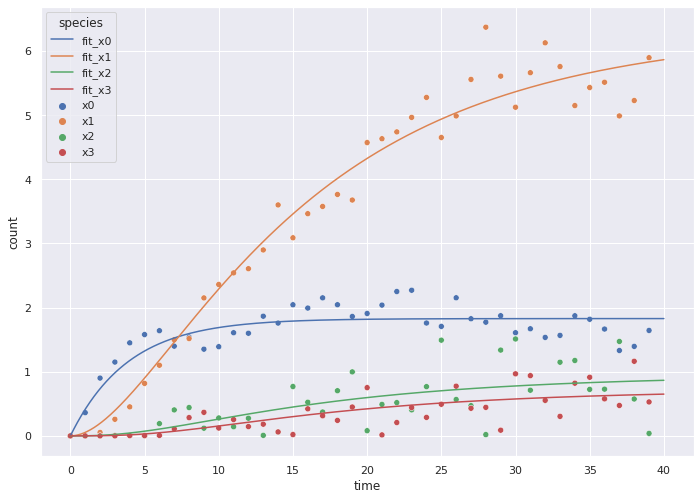

<AxesSubplot:xlabel='time', ylabel='count'>

In [27]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
measured = np.concatenate((time.reshape(-1,1), x), axis=1)
plot_fitted_odes(data_fitted, t_fit, measured, result)

In [23]:
# | export 

In [24]:
# | export 

In [28]:
#| hide
import nbdev; nbdev.nbdev_export()